In [90]:
import numpy as np
from tensorflow import keras
from keras import layers
from stacked_mnist import StackedMNISTData, DataMode
import matplotlib.pyplot as plt


In [91]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 8


In [92]:
input_img = keras.Input(shape=(28, 28, 1))

# Encoder
# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Flatten()(x)
h = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)



In [93]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [94]:
# Create encoder
encoder = keras.Model(input_img, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = layers.Dense(1568, activation='relu')(x)
x = layers.Reshape((7, 7, 32))(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
outputs = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(input_img)[2])
vae = keras.Model(input_img, outputs, name='vae_mlp')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_29 (Conv2D)             (None, 28, 28, 32)   320         ['input_16[0][0]']               
                                                                                                  
 max_pooling2d_19 (MaxPooling2D  (None, 14, 14, 32)  0           ['conv2d_29[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 14, 14, 32)   9248        ['max_pooling2d_19[0][0]'] 

In [95]:
reconstruction_loss = keras.losses.binary_crossentropy(input_img, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [96]:
generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
x_test = x_test[:, :, :, [0]]
y_test = keras.utils.to_categorical((y_test % 10).astype(np.int), 10)
print(x_train.shape)
print(x_test.shape)
vae.fit(x_train, x_train,
        epochs=50,
        batch_size=32,
        validation_data=(x_test, x_test))

(60000, 28, 28, 1)
(10000, 28, 28, 1)
Epoch 1/50


ValueError: in user code:

    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "tf.__operators__.add_31" (type TFOpLambda).
    
    Dimensions must be equal, but are 28 and 32 for '{{node vae_mlp/tf.__operators__.add_31/AddV2}} = AddV2[T=DT_FLOAT](vae_mlp/tf.math.multiply_29/Mul, vae_mlp/tf.math.multiply_30/Mul)' with input shapes: [32,28,28], [32].
    
    Call arguments received:
      • x=tf.Tensor(shape=(32, 28, 28), dtype=float32)
      • y=tf.Tensor(shape=(32,), dtype=float32)
      • name=None


In [7]:
x_test_encoded = encoder.predict(x_test)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

TypeError: list indices must be integers or slices, not tuple

<Figure size 432x432 with 0 Axes>

In [15]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

ValueError: in user code:

    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "decoder" is incompatible with the layer: expected shape=(None, 8), found shape=(None, 2)


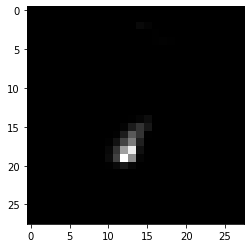

In [29]:
z_sample = np.random.standard_normal((10, 8))
x_decoded = decoder.predict(z_sample)

plt.figure(figsize=(5, 4))
for i in range(1, 5):
    plt.imshow(x_decoded[i].reshape(28, 28))
    plt.gray()
plt.show()